# Large-scale modelling and simulation project

University: Gustave Eiffel

Class: M2-SIA

Students: 
- Tran Le Tuan Nguyen 
- Collet Ian 
- Louis Thidet

Supervisor: Dr. Sebastian Horl

This project is to perform a modelling and agent-based transport simulation in a French city. 

- The anwser for questions in each Exercise are provided in the number list. Eg., Section `1.1.a` provides answer to the first question for Exercise `1.1`.
- The analysis steps are provided in bullter points.

## 1.0 Import necessary tools and data files

In [81]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as sgeo
import plotly.express as px
import os
import numpy.linalg as la


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [82]:
current_dir = os.getcwd()
data_dir = current_dir + "/data"

municipalities_data =  data_dir + "/municipalities.parquet"

## 1.1 Study Area 

- First, we read the municipalities data (contaning the spatial shapes of the municipalities in France).
- The raw data format can be found at  https://geoservices.ign.fr/contoursiris (2021 version).
- In this study, we take advantage of the cleanded data format, which can be found from here: https://drive.google.com/drive/folders/1ut28N-SBsaDlWXudfgfQjgOxZfCnEd8C.

In [83]:
# geopandas
df_municipalities = gpd.read_parquet(municipalities_data)
df_municipalities.head()

,municipality_id,geometry,iris_id,department_id
0,01001,"POLYGON ((851129.600 6563369.200, 851107.500 6...",010010000,01
1,01002,"POLYGON ((889113.200 6549307.800, 889111.600 6...",010020000,01
2,01004,"POLYGON ((882936.400 6541364.300, 882932.900 6...",010040102,01
3,01005,"POLYGON ((846758.000 6544007.000, 846755.000 6...",010050000,01
4,01006,"POLYGON ((900682.500 6518954.000, 900466.600 6...",010060000,01


#### a. We choose the city Strasbourg, which is located at the east of France. Strasbourg has municipalicty ID "67482", and its department are Bas-Rhin with the ID "67"

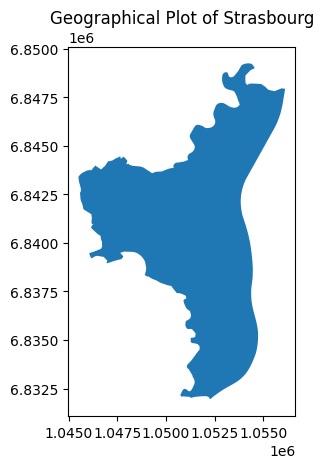

In [84]:
Strasbourg_id = "67482"
Strasbourg_df = df_municipalities[df_municipalities['municipality_id'].str[:5] == Strasbourg_id]
ax = Strasbourg_df.plot()
ax.set_title("Geographical Plot of Strasbourg")
plt.show()

#### b. We visualize the Bas-Rhin department on the map with geopandas, and highlight the chosen municipality (Strasbourg) as blue color, and its neighbours as red color

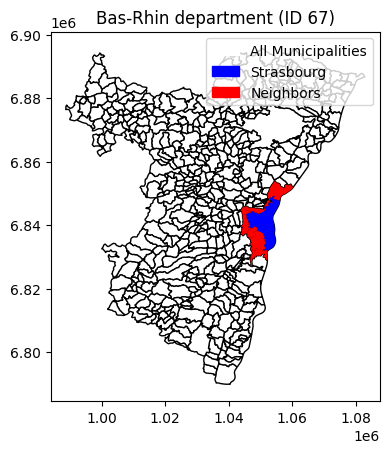

In [85]:
# All municipalities in the department 67
department_id = df_municipalities[df_municipalities['department_id'].str[:2] == "67"]
ax = department_id.plot(color='white', edgecolor='black', label='All Municipalities')

# Highlight Strasbourg
df_municipalities[df_municipalities['municipality_id'] == Strasbourg_id].plot(color='blue', ax=ax, label='Strasbourg')

# Neighbors of Strasbourg
neighbors = ['67131', '67218', '67365', '67267', '67118', '67343', '67296', '67447', '67519']
department_id[department_id['municipality_id'].isin(neighbors)].plot(color='red', ax=ax, label='Neighbors')

# Create legend handles
handles = [
    mpatches.Patch(color='white', label='All Municipalities'),
    mpatches.Patch(color='blue', label='Strasbourg'),
    mpatches.Patch(color='red', label='Neighbors')
]

# Add legend with handles
plt.legend(handles=handles)

# Set the title
plt.title('Bas-Rhin department (ID 67)')

# Show the plot
plt.show()

- We save the studied area as a gpkg file for visualization in QGIS software

In [86]:
department_id.to_file("studied_area.gpkg")

## 1.2 Territorial analysis I

We read the census data (which describes characteristics of each person in certain area in France)

- The data can be found in here: https://www.insee.fr/fr/statistiques/6544333#consulter

Variables: 

- IRIS: identifier for the location of the observation in France, load it as `str`
- IPONDI: a weight of each observation, load it as `float`
- AGED: the age of each observation, load it as `int`
- CS1: Socioprofessional category (Catégorie socioprofessionnelle en 8 postes) as `int`


In [87]:
columns = {
    "IRIS": str,
    "IPONDI": float,
    "AGED": int,
    "CS1": int
}

census_data = data_dir + "/FD_INDCVI_2019.csv"
# data about characteristics of each person in certain area
df_census = pd.read_csv(census_data, sep = ";", dtype = columns, usecols = columns.keys())
df_census.head()

,AGED,CS1,IPONDI,IRIS
0,68,7,3.324481,010040101
1,33,6,2.957422,010040202
2,1,8,2.957422,010040202
3,30,6,2.957422,010040202
4,72,7,5.046771,ZZZZZZZZZ


- Next, we rename the columns of census data for better readability

In [88]:
df_census = df_census.rename(columns = {
    "IRIS": "iris_id",
    "IPONDI": "weight",
    "AGED": "age",
    "CS1": "csp"
})

df_census.head()

,age,csp,weight,iris_id
0,68,7,3.324481,010040101
1,33,6,2.957422,010040202
2,1,8,2.957422,010040202
3,30,6,2.957422,010040202
4,72,7,5.046771,ZZZZZZZZZ


#### a. Provide a list of municipality identifiers for all the municipalities included in the study area.

- We utilize the municipalities data to provide a list of ID for all the municipalities in the study area (Bas-Rhin department).
- We can see that there are 514 municipalities in the study area.

In [89]:
df_municipalities[df_municipalities['department_id'].str[:2] == "67"]

,municipality_id,geometry,iris_id,department_id
26127,67001,"POLYGON ((1040988.200 6839392.900, 1040914.800...",670010000,67
26128,67002,"POLYGON ((1006325.400 6876464.400, 1006355.100...",670020000,67
26129,67003,"POLYGON ((1018753.300 6814830.700, 1018755.700...",670030000,67
26130,67004,"POLYGON ((1019659.800 6849380.600, 1019699.600...",670040000,67
26131,67005,"POLYGON ((1038941.700 6865681.100, 1038947.600...",670050000,67
...,...,...,...,...
26636,67555,"POLYGON ((1026320.400 6850784.300, 1026353.000...",675550000,67
26637,67556,"POLYGON ((1030467.400 6852288.700, 1030439.400...",675560000,67
26638,67557,"POLYGON ((1032259.800 6821503.800, 1032336.500...",675570000,67
26639,67558,"POLYGON ((1033867.200 6880068.100, 1033889.300...",675580000,67


#### b.  In a table, provide the number of samples (data points) in the census data for each municipality along with the weighted population count (including zero). 

- In the census data, the `weight` represents the number of samples associated with each municipality. Taking the `sum` of these weights will get us the total population represented by the data for each municipality, taking into account the sample sizes.

- To see how many samples contribution to the population count, we count the `weight`and get the the actual number of data points used for each municipality.

In [90]:
weighted_population_count = df_census.groupby('iris_id')['weight'].sum()
number_of_samples = df_census.groupby('iris_id')['weight'].count()
table = pd.DataFrame({'iris_id': weighted_population_count.index,
                   'weighted_population_count': weighted_population_count.values,
                   'number_of_samples': number_of_samples.values})

table

,iris_id,weighted_population_count,number_of_samples
0,010040101,1.896820e+03,802
1,010040102,3.597839e+03,1665
2,010040201,4.118478e+03,1553
3,010040202,4.532863e+03,1803
4,010330102,2.918102e+03,1141
...,...,...,...
15907,974240102,1.677028e+03,330
15908,974240103,7.254382e+02,143
15909,974240104,1.029640e+03,204
15910,974240105,3.841862e+02,77


#### c. Plot the age distribution of the study area and at least three municipalities in the study area.

- Recall that Strasbourg has the iris_id starting by "67482" (example : "674821202"), and its three neighbours are : Illkirch-Graffenstaden (starting with "67218"), Ostwald (starting with "67365") and Schiltigheim (starting with "67447").
- We get all the iris zone corresponding to the cities, by using their code.
- We perform the `group by` for the `age` column, and take the `sum` for the `weight` column to get the number of people at certain age in each municipality.
- We also perform the `group by` for the `csp` column, and take the `sum` for the `weight` column to get the number of people in a specific `csp`.

In [91]:
# Find all the chosen cities using their iris_id
city_Strasbourg= df_census[df_census['iris_id'].str.startswith("67482")]
city_Illkirch_Graffenstaden = df_census[df_census['iris_id'].str.startswith("67218")]
city_Ostwald = df_census[df_census['iris_id'].str.startswith("67365")]
city_Schiltigheim = df_census[df_census['iris_id'].str.startswith("67447")]

# Calculate the number of people at certain age in all the chosen cities
age_Strasbourg= city_Strasbourg.groupby('age')["weight"].sum().reset_index()
age_Illkirch_Graffenstaden = city_Illkirch_Graffenstaden.groupby('age')["weight"].sum().reset_index()
age_Ostwald = city_Ostwald.groupby('age')["weight"].sum().reset_index()
age_Schiltigheim = city_Schiltigheim.groupby('age')["weight"].sum().reset_index()

# Calculate the number of people at specific csp in all the chosen cities
csp_Strasbourg= city_Strasbourg.groupby('csp')["weight"].sum().reset_index()
csp_Illkirch_Graffenstaden = city_Illkirch_Graffenstaden.groupby('csp')["weight"].sum().reset_index()
csp_Ostwald = city_Ostwald.groupby('csp')["weight"].sum().reset_index()
csp_Schiltigheim = city_Schiltigheim.groupby('csp')["weight"].sum().reset_index()

- We plot the age distribution of Strasbourg and its neighbours.

In [92]:
# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Strasbourg", "Illkirch-Graffenstaden", "Ostwald", "Schiltigheim"))

# Add the bar charts to the subplots
fig.add_trace(go.Bar(x=age_Strasbourg["age"], y=age_Strasbourg["weight"]), row=1, col=1)
fig.add_trace(go.Bar(x=age_Illkirch_Graffenstaden["age"], y=age_Illkirch_Graffenstaden["weight"]), row=1, col=2)
fig.add_trace(go.Bar(x=age_Ostwald["age"], y=age_Ostwald["weight"]), row=2, col=1)
fig.add_trace(go.Bar(x=age_Schiltigheim["age"], y=age_Schiltigheim["weight"]), row=2, col=2)

# Update the x-axis labels
fig.update_xaxes(title_text="age", row=1, col=1)
fig.update_xaxes(title_text="age", row=1, col=2)
fig.update_xaxes(title_text="age", row=2, col=1)
fig.update_xaxes(title_text="age", row=2, col=2)

# Update the layout
fig.update_layout(height=600, width=800, title_text="Population Distribution by Age")

# Show the plot
fig.show()

Analysis of population distribution by age in the four plotted cities:

1. `Strasbourg's dominance of middle-aged population`:
- Strasbourg, represented in blue, exhibits the largest population of middle-aged individuals, ranging from 20 to 40 years old.
- The population count within this age range falls between 4000 and 6000 people.

2. `Similarity in age distribution`:
- There is a some similarity in the age distribution among the four cities.
- As the age increases, the number of people decreases, particularly for individuals aged 50 and above.

3. `Ostwald's sparse population`:
- Ostwald stands out as a sparsely populated city, particularly among young individuals.
- The population count for individuals between the ages of 0 and 25 is relatively low, ranging from 100 to 200 people.

#### d. Plot the distribution of social-professional categories of the study area and of at least three municipalities in the study area. 

In [93]:
# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Strasbourg", "Illkirch_Graffenstaden", "Ostwald city", "Schiltigheim city"))

# Add the bar charts to the subplots
fig.add_trace(go.Bar(x=csp_Strasbourg["csp"], y=csp_Strasbourg["weight"]), row=1, col=1)
fig.add_trace(go.Bar(x=csp_Illkirch_Graffenstaden["csp"], y=csp_Illkirch_Graffenstaden["weight"]), row=1, col=2)
fig.add_trace(go.Bar(x=csp_Ostwald["csp"], y=csp_Ostwald["weight"]), row=2, col=1)
fig.add_trace(go.Bar(x=csp_Schiltigheim["csp"], y=csp_Schiltigheim["weight"]), row=2, col=2)

# Update the x-axis labels
fig.update_xaxes(title_text="csp", row=1, col=1)
fig.update_xaxes(title_text="csp", row=1, col=2)
fig.update_xaxes(title_text="csp", row=2, col=1)
fig.update_xaxes(title_text="csp", row=2, col=2)

# Update the layout
fig.update_layout(height=600, width=800, title_text="Population Distribution by Social-Professional Categories ")

# Show the plot
fig.show()

Analysis of the population distribution by social-professional categories:

1. `Dominant Group`:

- The largest group across all analyzed cities is csp 8, representing individuals with no professional activity.
- Strasbourg has the highest number of individuals in this category, with more than 100,000 people.

2. `Similarities in Population Distribution`:

- There are similarities in the population distribution among the four cities.
- Categories csp 3, 4, and 5, which typically include skilled workers and professionals, are consistently in the middle-high range of the distribution.
- The differences between these categories among the cities are relatively small.

3. `Unique Observation`:

- Interestingly, the cities of Illkirch_Graffenstaden, Ostwald, and Schiltigheim have a very small population in csp 2, which represents artisans, traders, and business leaders.
- The number of individuals in this category is less than 1,000 across these three cities.


## 1.3 Territorial analysis II

- First, we read the population data, which indicates the characteristics of the population by sex, age, socio-professional category and category nationality.
- The data can be found in: https://www.insee.fr/fr/statistiques/6543200, with the title: "Population en 2019 - IRIS - France hors Mayotte".

In [94]:
population_data = data_dir + "/base-ic-evol-struct-pop-2019.CSV"

# Characteristics of the population by sex, age, socio-professional category and category nationality.
df_population = pd.read_csv(population_data, sep = ";", dtype = {
    "COM": "str"
}, usecols = ["COM", "P19_POP"] + ["C19_POP15P_CS{}".format(k) for k in range(1,9)])

for k in range(1, 9):
    df_population["csp_{}".format(k)] = df_population["C19_POP15P_CS{}".format(k)]
    
df_population = df_population[["COM", "P19_POP"] + ["csp_{}".format(k) for k in range(1,9)]]
df_population.columns = ["municipality_id", "population"] + ["csp_{}".format(k) for k in range(1,9)]
df_population = df_population.groupby("municipality_id").sum().reset_index()

- Get the first 5 rows of the population data.

In [95]:
# Example: municipality "01001", population = 779, including 15 people from social professional category 1
df_population.head()

,municipality_id,population,csp_1,csp_2,csp_3,csp_4,csp_5,csp_6,csp_7,csp_8
0,01001,779.0,15.565978,19.822632,76.142088,98.357964,100.516361,126.843164,152.541469,29.616393
1,01002,256.0,0.000000,21.265503,15.927908,26.460181,42.135589,10.596822,67.296631,21.726261
2,01004,14134.0,2.762881,327.166403,784.225660,1890.243930,1891.133347,2001.750487,2763.422684,1848.127141
3,01005,1751.0,4.913019,112.999439,112.999439,221.085859,294.781145,186.694725,338.998316,117.912458
4,01006,112.0,0.000000,0.000000,5.090909,25.454545,15.272727,15.272727,25.454545,5.090909


- We perform the `merge` between municipalities and population data to get the population information of all the cities in the studied area with department "67" and theirs spatial shapes.

In [96]:
# All the cities in the studied area with department 67
df_studied_areas_population = pd.merge(df_municipalities[df_municipalities["department_id"].str[:2] == "67"], 
                                       df_population)

df_studied_areas_population.head(3)

,municipality_id,geometry,iris_id,department_id,population,csp_1,csp_2,csp_3,csp_4,csp_5,csp_6,csp_7,csp_8
0,67001,"POLYGON ((1040988.200 6839392.900, 1040914.800...",670010000,67,2338.0,5.646152,54.866827,252.144924,245.426134,217.790997,198.858441,779.312893,218.214182
1,67002,"POLYGON ((1006325.400 6876464.400, 1006355.100...",670020000,67,390.0,9.848485,4.924242,4.924242,49.242424,34.469697,73.863636,113.257576,29.545455
2,67003,"POLYGON ((1018753.300 6814830.700, 1018755.700...",670030000,67,441.0,5.140441,14.723528,24.379381,53.270841,63.756696,58.812224,122.822350,32.632977


#### a. Create a bar plot indicating the number of inhabitants in each municipality of the study area. Also, provide this information on a map.

In [97]:
fig = px.bar(df_studied_areas_population, x='municipality_id', y='population')
fig.update_layout(title="The number of inhabitants in each municipality of the study area")
fig.show()

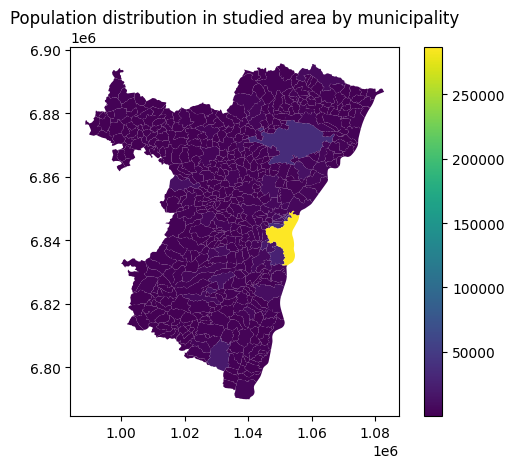

In [98]:
ax = df_studied_areas_population.plot("population", legend=True)
ax.set_title("Population distribution in studied area by municipality")
plt.show()

- Next, we read the employment data, which indicates the number of employees in the private sector, by municipality.
- The raw data format can be found from here: https://open.urssaf.fr/explore/dataset/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last/information/.

In [99]:
# Employment data per municipality 
data_employment = data_dir + "/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last.csv"
df_employment = pd.read_csv(data_employment, sep = ";", 
    usecols = ["Code commune", "Effectifs salariés 2019"], dtype = { "Code commune": str })

df_employment = df_employment.rename(columns = {
    "Code commune": "municipality_id",
    "Effectifs salariés 2019": "employment"
})

df_employment = df_employment.groupby("municipality_id").sum().reset_index()
df_employment.head()

,municipality_id,employment
0,01001,29.0
1,01002,2.0
2,01004,4859.0
3,01005,115.0
4,01007,302.0


#### b. Make use of the employment data to create a bar plot indicating the number of employees in each municipality of the study area. Also, provide this information on a map.

- First, we select the employment data for all municipalities in department "67".

In [100]:
df_studied_area_employee = df_employment[df_employment['municipality_id'].str[:2] == "67"]

- We plot the employment data of the studied area in the bar chart.

In [101]:
fig = px.bar(df_studied_area_employee, x='municipality_id', y='employment')
fig.update_layout(title="The number of employees in each municipality of the study area")
fig.show()

- We plot the employment data of the studied area in the map.

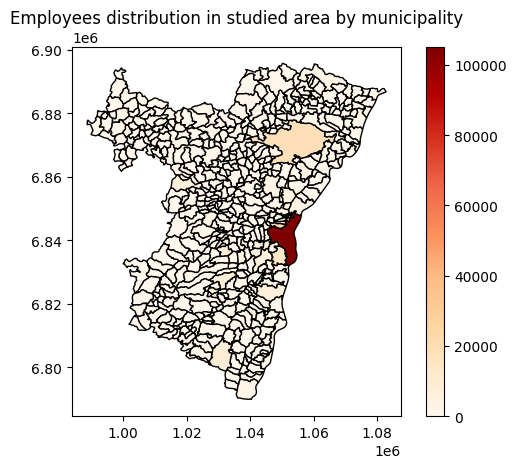

In [102]:
ax = pd.merge(df_municipalities[df_municipalities["department_id"].str[:2] == "67"], df_studied_area_employee).plot("employment", 
                                                                                                               legend=True,
                                                                                                               cmap='OrRd',
                                                                                                               edgecolor='black')

ax.set_title("Employees distribution in studied area by municipality")
plt.show()

#### c. Report the total number of inhabitants of the study area and the total number of employees in the study area.


- We caculate the total population and the number of employees from private sectors in the study area.

In [103]:
df_studied_areas_population['population'].sum(), df_studied_area_employee['employment'].sum()

(1140057.0, 353450.0)

- In the whole study area (Bas-Rhin department), the region has around 1,140,057 people, and 353,450 of them are employees from the private sectors, which makes up 30% of the total population.

- From the map by population and map by employees in sections `1.3.a` and `1.3.b`, we can see that Strasbourg has more than 250,000 inhabitants, and about 100,000 of them are employees from the private sectors, which accounts for above 25% the total population. 

##  2.1 Trip Production

- Working with multiple data frames is easier if we know that the order with respect to the keys is the same. 
- We can do so by indexing our data sets:

In [104]:
df_studied_areas_population = df_studied_areas_population.set_index("municipality_id")
df_studied_areas_population.head()

,geometry,iris_id,department_id,population,csp_1,csp_2,csp_3,csp_4,csp_5,csp_6,csp_7,csp_8
municipality_id,,,,,,,,,,,,
67001,"POLYGON ((1040988.200 6839392.900, 1040914.800...",670010000,67,2338.0,5.646152,54.866827,252.144924,245.426134,217.790997,198.858441,779.312893,218.214182
67002,"POLYGON ((1006325.400 6876464.400, 1006355.100...",670020000,67,390.0,9.848485,4.924242,4.924242,49.242424,34.469697,73.863636,113.257576,29.545455
67003,"POLYGON ((1018753.300 6814830.700, 1018755.700...",670030000,67,441.0,5.140441,14.723528,24.379381,53.270841,63.756696,58.812224,122.822350,32.632977
67004,"POLYGON ((1019659.800 6849380.600, 1019699.600...",670040000,67,1530.0,9.974091,59.908723,59.666117,209.409519,284.173254,218.674157,303.702195,139.949243
67005,"POLYGON ((1038941.700 6865681.100, 1038947.600...",670050000,67,850.0,10.126637,19.596259,99.576412,104.416631,80.052527,108.981000,187.408085,99.950085


- Next, we extract all csp columns that contain the population in each csp. We assign the result into the variable named `N`.
- We define the vector `parameters`, where each element of the vector is the growth factor for each csp.
- We then create the Trip Production model by making the dot product between the matrix `N` and vector `parameters`. 
- The output of the model is stored in the `O` variable. It is a vector size `(M,1)` where M is the number of studied municipalities (514 in total). 

In [105]:
csp_columns = ["csp_{}".format(k) for k in range(1,9)]

N = df_studied_areas_population.loc[:, csp_columns].values 
SCP_param_0 = 27.244
SCP_parameters = np.array([0.319, 0.994, 0.863, 0.990, 0.780, 0.708, 0.120, -0.073])
SCP_parameters = SCP_parameters.reshape(len(SCP_parameters), 1)

O = np.dot(N, SCP_parameters) + SCP_param_0 

In [106]:
O.shape 

(514, 1)

- We then intergrate the output of the model (the number of generated trips for municipalities) into the dataframe.

In [107]:
O = O.reshape(len(O))
trips = np.maximum(O, 0.0)

df_studied_areas_population['originating_trip'] = trips

#### a. Report how many trips have been generated in total.

In [108]:
sum(trips) # 495,232 trips generated by the model   

495500.08000067284

#### b. Report using a plot how many trips have been generated for each municipality in the study area. Also, show this information on a map.

- First, we convert the df_studied_areas_population datframe into geodataframe.

In [109]:
gpd_studied_areas_population = gpd.GeoDataFrame(df_studied_areas_population, geometry=df_studied_areas_population['geometry'])

- We plot the number of trips generated for each municipality.

In [110]:
fig = px.bar(gpd_studied_areas_population['originating_trip'])
fig.update_layout(title="The number of trips generated in each municipality of the study area")
fig.show()


- We provide the number of trips generated for each municipality on the map of the studied area.

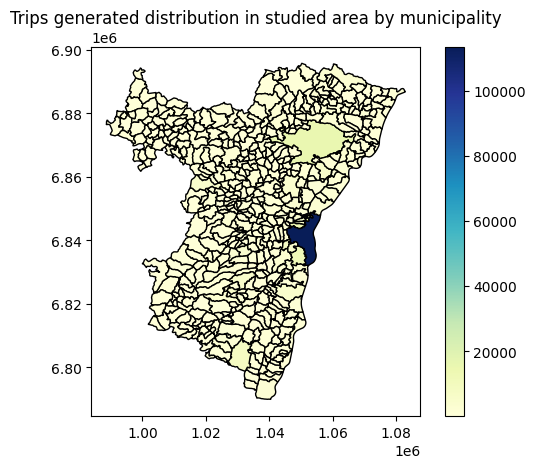

In [111]:
ax = gpd_studied_areas_population.plot("originating_trip", legend=True, cmap='YlGnBu', edgecolor='black')
ax.set_title("Trips generated distribution in studied area by municipality")
plt.show()

## 2.2 Trip Attraction

- We first set the index for the employment data as municipality_id
- In the employment data, there are some missing municipalities compared to the population data, so we find the missing municipalities and drop them in the population data.

In [112]:
df_studied_area_employee = df_studied_area_employee.set_index("municipality_id")

population_indices = df_studied_areas_population.index.values
employment_indices = df_studied_area_employee.index.values
missing_values = []

for i in range(len(population_indices)):
    if population_indices[i] not in employment_indices:
        missing_values.append(population_indices[i])
missing_values

['67050', '67079', '67556']

In [113]:
# Drop the missing municipalities
df_studied_areas_population.drop(index=missing_values, inplace=True)

In [114]:
print("The number of municipalities after removing missing zones:", df_studied_area_employee.shape[0])
print("Example of the fist 5 employment data: ")
df_studied_area_employee.head()

The number of municipalities after removing missing zones: 511
Example of the fist 5 employment data: 


,employment
municipality_id,
67001,401.0
67002,70.0
67003,2.0
67004,157.0
67005,48.0


- We calculate the arriving trips in each municipality, using the following formulas:

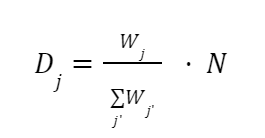

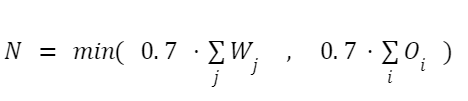

- Where $D_j$ is the arriving_trip in municipality $j$,
- $W_j$ is the number of employees in municipality $j$,
- $\sum_{j} W_j$ is the total employees,
- $N$ is the total number of commuters in municipality $j$.

In [115]:
total_originating_trips = df_studied_areas_population['originating_trip'].sum()
total_employment = df_studied_area_employee['employment'].sum()
employment = df_studied_area_employee['employment'].values

total_trips = min(0.7 * total_employment, 0.7 * total_originating_trips)
arriving_trips = ( employment / (total_employment) ) * total_trips

In [116]:
df_studied_areas_population['arriving_trips'] = arriving_trips

#### a. Report using a plot how many arriving trips have been generated for each municipality in the study area. Also, show this information on a map.

- We plot the number of arriving trips generated in each municipality in the study area.

In [117]:
gpd_arriving_trips = gpd.GeoDataFrame(df_studied_areas_population, geometry=df_studied_areas_population['geometry'])
fig = px.bar(gpd_arriving_trips['arriving_trips'])
fig.update_layout(title="The number of arriving trips generated in each municipality of the study area")
fig.show()

- We provide the number of arriving trips generated for each municipality on the map of the studied area.

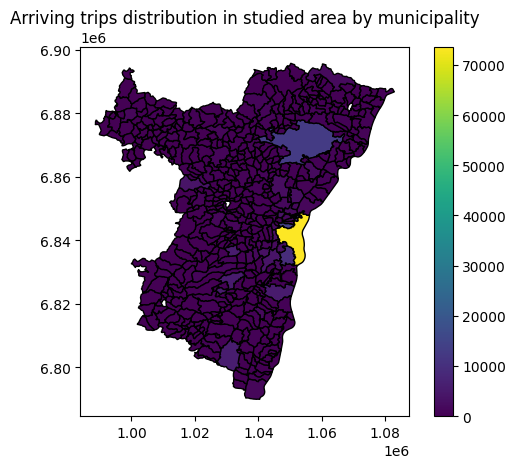

In [118]:
ax = gpd_arriving_trips.plot("arriving_trips", legend=True, edgecolor='black')
ax.set_title("Arriving trips distribution in studied area by municipality")
plt.show()

- In a balance model, the total of inflows must equal to the total of outflows. To ensure this condition, we scale the demand for each zone.

In [119]:
df_studied_areas_population['originating_trip'] = total_trips * (df_studied_areas_population['originating_trip'] / 
                                                                df_studied_areas_population['originating_trip'].sum())

## 2.3 Trip Distribution

- First, we calculate the distance between zone $i$ and zone $j$.
- The distance is calculated by using the Euclidean distance between the centroids of zones.
- The result is the distance matrix that estimates the distance between zone $i$ and zone $j$.

In [120]:
centroids = df_studied_areas_population["geometry"].centroid
centroids = np.array([centroids.x, centroids.y] ).T

distance_matrix = np.zeros((len(df_studied_areas_population), len(df_studied_areas_population)))

for k in range(len(df_studied_areas_population)):
    # Calculate the Euclidean distance
    distance_matrix[k,:] = la.norm(centroids[k] - centroids, axis = 1)

- We then calculate the friction term by using the following model:
- The result is a friction matrix that estimates how difficult to go from zone $i$ to zone $j$.

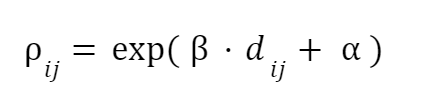

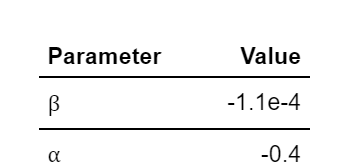

In [121]:
beta = -1 * 1e-4
alpha = -0.4

friction_matrix = np.exp(beta * distance_matrix + alpha)

- Next, we compute the production and attraction terms iteratively (500 loops) until they converge:

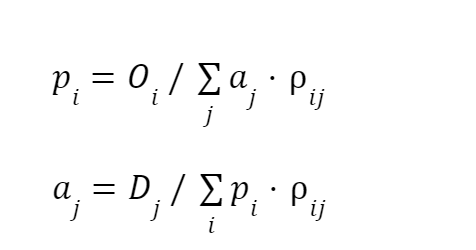

- Where $p_i$ is the production term of zone $i$,
- $O_i$ is the number of originating_trips in zone $i$, 
- $a_j$ is the attraction term of zone $j$,
- $p_{i,j}$ is the friction term between zone $i$ and zone $j$.

In [122]:
outflow = df_studied_areas_population['originating_trip'].values
inflow = df_studied_areas_population['arriving_trips'].values

productions = np.ones((len(distance_matrix),))
attractions = np.ones((len(distance_matrix),))

for iteration in range(500):
    for i in range(len(productions)):
        productions[i] = outflow[i] / np.sum(attractions * friction_matrix[i,:])

    for j in range(len(attractions)):
        attractions[j] = inflow[j] / np.sum(productions * friction_matrix[:,j])

- Finally, we calculate the flow matrix $F_{i, j}$ that indicates the movements from zone $i$ to zone $j$. This is achieved by using the following double-constrained gravity model:

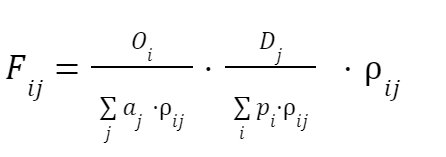

In [123]:
flow_matrix= np.copy(friction_matrix)

for i in range(len(distance_matrix)):
    flow_matrix[i,:] *= outflow[i] / np.sum(attractions * friction_matrix[i,:])

for j in range(len(distance_matrix)):
    flow_matrix[:,j] *= inflow[j] / np.sum(productions * friction_matrix[:,j])

#### a. Show the distance matrix as a table or in a plot.

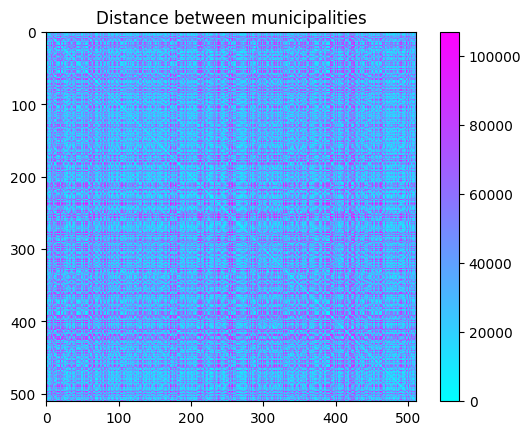

In [141]:
# Plotting the distance matrix
plt.imshow(distance_matrix, cmap='cool', interpolation='nearest')

# Adding color bar
plt.colorbar()

# Adding title 
plt.title("Distance between municipalities")

# Display the plot
plt.show()

- From the above distance matrix, it can be observed that most of the municipalities are quite close to each other (with shaded blue). Also, we can see that the municipalities ranging from 67300 to 67400 have the farthest distance (with violet color) to other zones.

#### b. Report the resulting flows $F_{i,j}$ in a table or plot.

In [125]:
municipality_id =  df_studied_areas_population.index 

df_flow_matrix = pd.DataFrame({"origin_id": municipality_id, 
                               "destination_id": municipality_id,
                               })

df_flow_matrix = df_flow_matrix.set_index(["origin_id", "destination_id"]).reindex(
    pd.MultiIndex.from_product([municipality_id, municipality_id], names=["origin_id", "destination_id"])
)

df_flow_matrix['flow'] = flow_matrix.reshape((-1))

In [126]:
df_flow_matrix

flow
origin_id destination_id          
67001     67001           2.097507
          67002           0.004384
          67003           0.000605
          67004           0.139201
          67005           0.026174
...                            ...
67559     67554           0.021601
          67555           0.001496
          67557           0.001062
          67558           0.441061
          67559           0.089330

[261121 rows x 1 columns]

#### c. Which pair of zones has the highest flow? Which one has the lowest?

In [127]:
max_flow = df_flow_matrix['flow'].max()
min_flow =  df_flow_matrix['flow'].min()

max_flow_pair_zones = df_flow_matrix.index[df_flow_matrix['flow'] == max_flow]
min_flow_pair_zones = df_flow_matrix.index[df_flow_matrix['flow'] == min_flow]

In [128]:
print("The highest flows ({} people) are from zone {} to zone {}".format(max_flow, max_flow_pair_zones[0][0], max_flow_pair_zones[0][1]))
print("The lowest flows ({} people) are from zone {} to zone {}".format(min_flow, min_flow_pair_zones[0][0], min_flow_pair_zones[0][1]))

The highest flows (34370.14827853565 people) are from zone 67482 to zone 67482
The lowest flows (0.0 people) are from zone 67001 to zone 67017


- From the above analysis, we found that the the highest flows is occured in `Strasbourg (67482)`, where most people are commuting within the region
- On the other hand, there is no one commuting from zone `Achenheim (67001)` to zone `Baerendorf (67017)` 
- The figure below illustrates the distance between these zones:

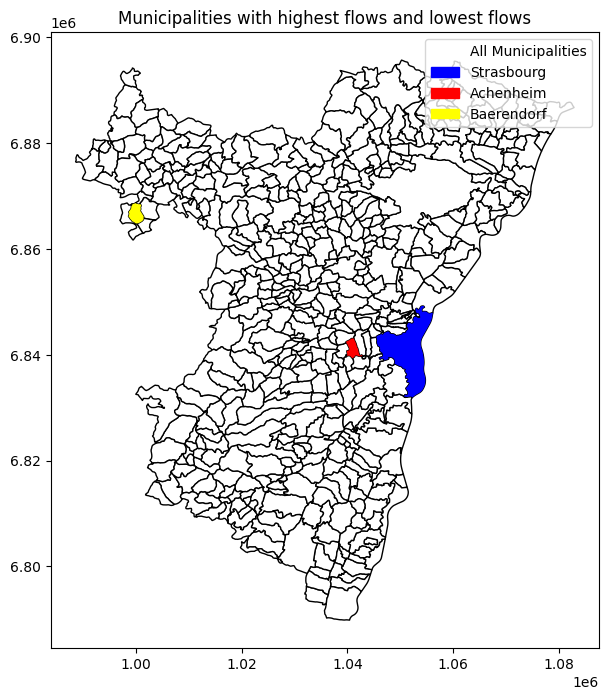

In [129]:
# Set the desired figure size
fig, ax = plt.subplots(figsize=(10, 8))

# All municipalities in the department 67
department_id.plot(color='white', edgecolor='black', label='All Municipalities', ax=ax)

# Highlight Strasbourg
df_municipalities[df_municipalities['municipality_id'] == Strasbourg_id].plot(color='blue', ax=ax, label='Strasbourg')

# Highlight Achenheim (67001)
department_id[department_id['municipality_id'] == "67001"].plot(color='red', ax=ax, label='Achenheim')

# Highlight Baerendorf (67017)
department_id[department_id['municipality_id'] == "67017"].plot(color='yellow', ax=ax, label='Baerendorf')

# Create legend handles
handles = [
    mpatches.Patch(color='white', label='All Municipalities'),
    mpatches.Patch(color='blue', label='Strasbourg'),
    mpatches.Patch(color='red', label='Achenheim'),
    mpatches.Patch(color='yellow', label='Baerendorf')
]

# Add legend with handles
plt.legend(handles=handles)

# Set the title
plt.title('Municipalities with highest flows and lowest flows') 

# Show the plot
plt.show()

## 3.1 Disaggregation 

- First, we calculate the probability of a trip can occur between zone $i$ and zone $j$

In [130]:
df_flow_matrix['probability'] = df_flow_matrix['flow'] / df_flow_matrix['flow'].sum()

In [131]:
df_flow_matrix

flow   probability
origin_id destination_id                        
67001     67001           2.097507  8.477688e-06
          67002           0.004384  1.771942e-08
          67003           0.000605  2.444898e-09
          67004           0.139201  5.626211e-07
          67005           0.026174  1.057911e-07
...                            ...           ...
67559     67554           0.021601  8.730826e-08
          67555           0.001496  6.046272e-09
          67557           0.001062  4.293759e-09
          67558           0.441061  1.782676e-06
          67559           0.089330  3.610548e-07

[261121 rows x 2 columns]

- Next, we sample 1000 trips from the flow matrix $F_{i,j}$.
- The 1000 trips samples are store in the df_trips variable.

In [132]:
df_trips = df_flow_matrix.sample(1000, weights = "probability", replace = True)
df_trips.reset_index(inplace=True)
df_trips = df_trips[['origin_id', 'destination_id']]

- For every sampled trip, we add a randomized departure time $T$, following normal distribution:

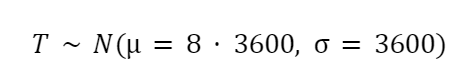

In [133]:
np.random.seed(0)
# Convert from hour to seconds for simulation 
df_trips['departure_time'] = np.maximum(0.0, (8 + np.random.normal(size=len(df_trips))) * 3600)
df_trips

,origin_id,destination_id,departure_time
0,67482,67482,35150.588445
1,67482,67118,30240.565950
2,67482,67482,32323.456743
3,67529,67118,36867.215517
4,67482,67482,35523.208765
...,...,...,...
995,67359,67067,30286.334954
996,67447,67482,28085.763971
997,67482,67482,29139.092281
998,67411,67493,24668.600599


- For every sampled trip (or each pair of zones), we sample a random origin coordinate, and a destination coordinate from within their respective zones.
- We achieve this by first merging the generated sample trips (df_trips) and their geometry shapes (polygon).
- Then for each trip, we sample a random coordinate (point) within its polygon.

In [134]:
df_trips = pd.merge(df_trips, df_studied_areas_population.reset_index()[['municipality_id', 'geometry']]
                    .rename(columns={"municipality_id": "origin_id", "geometry": "origin_geometry"}), on="origin_id")

df_trips = pd.merge(df_trips, df_studied_areas_population.reset_index()[['municipality_id', 'geometry']]
                    .rename(columns={"municipality_id": "destination_id", "geometry": "destination_geometry"}), on="destination_id")

df_trips = gpd.GeoDataFrame(df_trips, geometry="origin_geometry")
df_trips['origin_geometry'] = df_trips.sample_points(1)

df_trips = df_trips.set_geometry("destination_geometry")
df_trips["destination_geometry"] = df_trips.sample_points(1)

df_trips.head()

,origin_id,destination_id,departure_time,origin_geometry,destination_geometry
0,67482,67482,35150.588445,POINT (1045775.033 6842370.709),POINT (1052609.983 6845235.782)
1,67482,67118,30240.565950,POINT (1051369.976 6841862.579),POINT (1045673.455 6840621.099)
2,67482,67482,32323.456743,POINT (1051514.673 6843242.748),POINT (1053403.757 6839952.398)
3,67529,67118,36867.215517,POINT (1057424.145 6858770.283),POINT (1044831.561 6842218.330)
4,67482,67482,35523.208765,POINT (1048369.276 6842692.051),POINT (1052610.259 6840381.072)


#### a. Plot the generated trip pairs on a map using a line between origin and destination.

- We make a line string between each sampled origin and destination coordinates.

In [135]:
df_trips["geometry"] = [
    sgeo.LineString(od) 
    for od in zip(df_trips["origin_geometry"], df_trips["destination_geometry"])
]

- Then we plot the generated trip pairs on a map. 

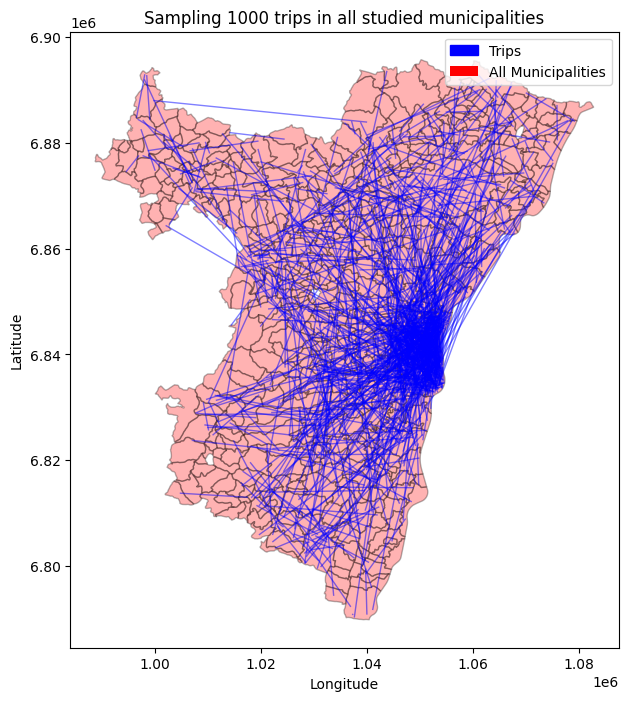

In [136]:
df_trips = df_trips.set_geometry("geometry")

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot df_trips with transparency to avoid overlapping points
df_trips.plot(ax=ax, color='blue', alpha=0.5, linewidth=1, marker='o', markersize=3, label='Trips')

# Plot df_studied_areas_population with a filled style
df_studied_areas_population.plot(ax=ax, facecolor='red', edgecolor='black', alpha=0.3, label='All Municipalities')

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Sampling 1000 trips in all studied municipalities')

# Create legend handles
handles = [
    mpatches.Patch(color='blue', label='Trips'),
    mpatches.Patch(facecolor='red', label='All Municipalities')
]

# Add legend with handles
plt.legend(handles=handles)

# Show the plot
plt.show()

- From the above figure, we can see that the high density of trips are focusing within Strasbourg (region on the middle east of the map)

#### b. Plot the distribution of the departure times as a histogram or CDF.

Text(0.5, 1.0, 'The distribution of the departure times as a historgram')

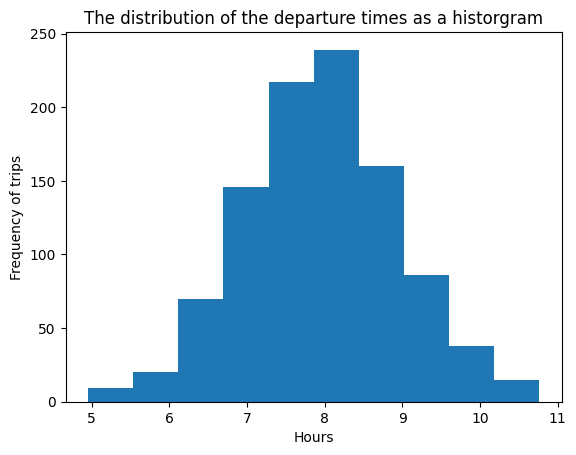

In [137]:
plt.hist(df_trips["departure_time"] / 3600)
plt.xlabel("Hours")
plt.ylabel("Frequency of trips")
plt.title("The distribution of the departure times as a historgram")

- From the above histogram, we can see that the mean departure time is 8 hours, with high variance between 7-9 hours.

Text(0.5, 1.0, 'The distribution of the departure times as a CDF')

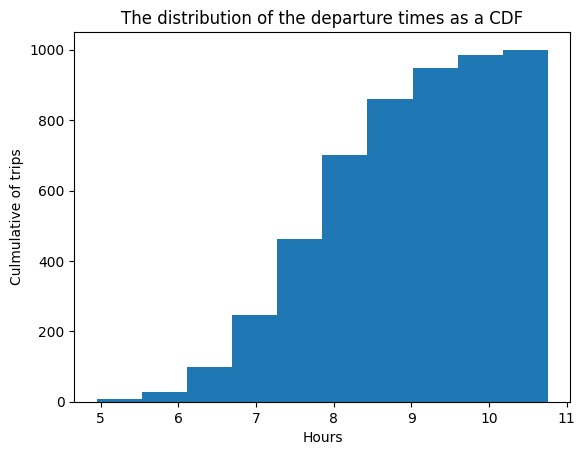

In [138]:
plt.hist(df_trips["departure_time"] /3600, cumulative=True)
plt.xlabel("Hours")
plt.ylabel("Culmulative of trips")
plt.title("The distribution of the departure times as a CDF")

- From the above CDF, we can see that there are around 500 trips generated within the duration less than 8 hours.